# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Table of Contents
1. [Data Exploration](#data-exploration)<br>
2. [Data Cleaning](#data-cleaning)<br>
3. [Exploratory Data Analysis](#data-analysis)<br>
4. [Data Modeling](#data-modeling)<br>

In [116]:
# import python libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

%matplotlib inline
sns.set(style="darkgrid")

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## <a class="anchor" id="data-exploration">Data Exploration</a>

In this section I want to explore and evaluate data loaded from the datasets in order to define steps needed for cleaning.

### Portfolio dataframe

In [117]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


We can see that there are 10 different offers in the portfolio dataset.

In [118]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [119]:
#check for null values 
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

There are no missing values in portfolio dataset

There are no major issues regarding portfolio dataset, but there are some cleaning steps I want to apply to this dataset:

 - change column name for merge with other dataframes (id to offer_id)
 - channels will need to be broken up using string split and made into seperate columns

### Profile dataframe

In [120]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [121]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [122]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [123]:
#check for null values 
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

At first glance, I noticed that the "age" column has multiple occurrences of the value "118", which is odd. Also, every row where the age is 118 appears to have null values in the gender and income columns.

In [124]:
#check null values where age equals 118
print(profile[profile.age == 118].age.count())
print(profile[profile.age == 118].income.isnull().sum())
print(profile[profile.age == 118].gender.isnull().sum())

2175
2175
2175


We can confirm that both gender and income for the age 118 are missing

(array([ 611.,  697.,  649.,  789.,  972., 1082., 1607., 1776., 1727.,
        1530., 1174.,  857.,  591.,  375.,  256.,  105.,   27.,    0.,
           0., 2175.]),
 array([ 18.,  23.,  28.,  33.,  38.,  43.,  48.,  53.,  58.,  63.,  68.,
         73.,  78.,  83.,  88.,  93.,  98., 103., 108., 113., 118.]),
 <BarContainer object of 20 artists>)

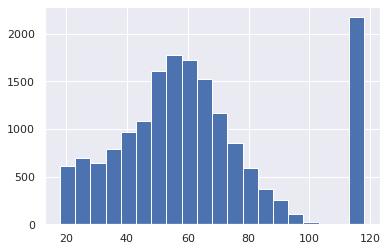

In [125]:
# check age distribution
plt.hist(profile.age, bins = 20)

/home/josip.naletilic/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


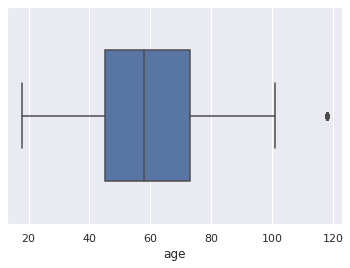

In [126]:
# boxplot to check the outliers
sns.boxplot(profile.age, width=0.6);

Cleaning tasks:
 - Classifying ages into generation groups and rename to generation:
    - Gen Z (Under 25)
    - Millennials (26 - 41)
    - Gen X (42 - 57)
    - Baby Boomers (58 - 76)
    - Silent Generation (Over 77)
 - delete the rows where age equals 118
 - replace became_member_on with year and rename to year
 - rename id to person to merge later with other dataframes

### Transcript dataframe

In [127]:
transcript.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [128]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [129]:
#check for null values
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

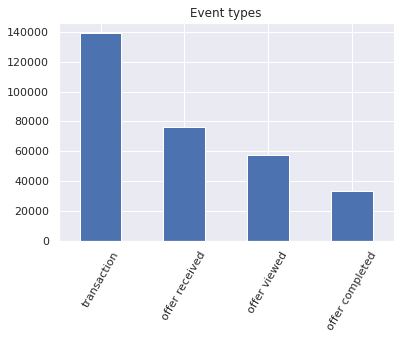

In [130]:
# Display event types
plt.title("Event types")
transcript.event.value_counts().plot(kind='bar')
plt.xticks(rotation=60)
plt.show()

Cleaning tasks:
 - extract the value and create a new column for each value
 - merge two resulting columns
 - rename columns for later merge

## <a class="anchor" id="data-cleaning">Data Cleaning</a>

### Portfolio dataframe

Cleaning tasks:
 - change column name for merge with other dataframes (id to offer_id)
 - channels will need to be broken up using string split and made into seperate columns
 - drop channels column

In [131]:
portfolio_clean = portfolio.copy()
portfolio_clean.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [132]:
# function for renaming column
def rename_columns(df, new_column_names):
    """
    Parameters
    ----------
    df: input dataframe
    new_column_names: define new column name for each column
    
    Returns
    -------
    df: output data frame with renamed column names
       
    """

    df= df.rename(columns = new_column_names,inplace=True)
    return df

In [133]:
# rename id column name from id to offer_id
rename_columns(portfolio_clean, {'id':'offer_id'})

In [134]:
portfolio_clean.head()

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [135]:
# Create columns of 1's and 0's for channel type
channels = set()
for item in portfolio_clean.channels:
    channels.update(set(item))

for item in channels:
    portfolio_clean[item] = portfolio_clean.channels.apply(lambda x: 1 if item in x else 0)
    
portfolio_clean.head()

,reward,channels,difficulty,duration,offer_type,offer_id,web,email,social,mobile
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


In [136]:
# drop channels column
portfolio_clean.drop(['channels'], axis = 1, inplace=True)

In [137]:
portfolio_clean

,reward,difficulty,duration,offer_type,offer_id,web,email,social,mobile
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


### Profile dataframe

Cleaning tasks:
 - drop the rows where age equals 118
 - Classifying ages into generation groups and rename to generation:
    - Gen Z (Under 25)
    - Millennials (26 - 41)
    - Gen X (42 - 57)
    - Baby Boomers (58 - 76)
    - Silent Generation (Over 77)
 - replace became_member_on with year and rename to year
 - rename id to person to merge later with other dataframes

In [138]:
profile_clean = profile.copy()
profile_clean.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [139]:
# drop the rows where age equals 118
profile_clean = profile_clean[profile_clean.age != 118]

# classifying ages into groups
profile_clean.age = pd.cut(profile_clean.age, bins=[0, 25, 41, 57, 76, 118], 
                               labels=['Gen Z', 'Millennials', 'Gen X', 'Baby Boomers', 'Silent Generation'])

# rename age column name from age to generation
rename_columns(profile_clean, {'age':'generation'})

profile_clean.head()

,gender,generation,id,became_member_on,income
1,F,Gen X,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,Baby Boomers,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,Baby Boomers,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,Baby Boomers,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,Baby Boomers,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


In [140]:
# replace became_member_on with year and rename to year
profile_clean.became_member_on = pd.to_datetime(profile_clean.became_member_on, format = '%Y%m%d').apply(lambda x:x.year)

rename_columns(profile_clean, {'became_member_on':'year'})

profile_clean.head()

,gender,generation,id,year,income
1,F,Gen X,0610b486422d4921ae7d2bf64640c50b,2017,112000.0
3,F,Baby Boomers,78afa995795e4d85b5d9ceeca43f5fef,2017,100000.0
5,M,Baby Boomers,e2127556f4f64592b11af22de27a7932,2018,70000.0
8,M,Baby Boomers,389bc3fa690240e798340f5a15918d5c,2018,53000.0
12,M,Baby Boomers,2eeac8d8feae4a8cad5a6af0499a211d,2017,51000.0


In [141]:
# check for null values
profile_clean.isnull().sum()

gender        0
generation    0
id            0
year          0
income        0
dtype: int64

In [142]:
profile_clean.head()

,gender,generation,id,year,income
1,F,Gen X,0610b486422d4921ae7d2bf64640c50b,2017,112000.0
3,F,Baby Boomers,78afa995795e4d85b5d9ceeca43f5fef,2017,100000.0
5,M,Baby Boomers,e2127556f4f64592b11af22de27a7932,2018,70000.0
8,M,Baby Boomers,389bc3fa690240e798340f5a15918d5c,2018,53000.0
12,M,Baby Boomers,2eeac8d8feae4a8cad5a6af0499a211d,2017,51000.0


In [143]:
# rename id to person to merge later with other dataframes
rename_columns(profile_clean, {'id':'person'})

profile_clean.head()

,gender,generation,person,year,income
1,F,Gen X,0610b486422d4921ae7d2bf64640c50b,2017,112000.0
3,F,Baby Boomers,78afa995795e4d85b5d9ceeca43f5fef,2017,100000.0
5,M,Baby Boomers,e2127556f4f64592b11af22de27a7932,2018,70000.0
8,M,Baby Boomers,389bc3fa690240e798340f5a15918d5c,2018,53000.0
12,M,Baby Boomers,2eeac8d8feae4a8cad5a6af0499a211d,2017,51000.0


In [144]:
# check duplicates
profile_clean.duplicated().sum()

0

### Transcript dataframe

Cleaning tasks:
 - extract the value and create a new column for each value
 - merge two resulting columns
 - rename column for later merge
 - fill null values

In [145]:
transcript_clean = transcript.copy()
transcript_clean.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [146]:
transcript_clean.tail()

,person,event,value,time
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


There are 4 possible values in value column: 'offer id', 'offer_id', 'reward' and 'amount', out of which 'offer id' and 'offer_id' are to be considered same.

In [147]:
# extract information from value column and create new column for each type
transcript_clean = pd.concat([transcript_clean, transcript_clean.value.apply(pd.Series)], axis=1)

# fix duplicated names of offer id and offer_id to have only one
transcript_clean['temp'] = np.where(transcript_clean['offer id'].isnull() & transcript_clean['offer_id'].notnull(), transcript_clean['offer_id'], transcript_clean['offer id'])
transcript_clean.drop(['value','offer id', 'offer_id'], axis=1, inplace=True)
rename_columns(transcript_clean, {'temp': 'offer_id'})
rename_columns(transcript_clean, {'reward': 'gained_reward'})

transcript_clean.head()

,person,event,time,amount,gained_reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [148]:
# fill null values
transcript_clean.amount.fillna(0, inplace=True)
transcript_clean.gained_reward.fillna(0, inplace=True)

transcript_clean.tail()

,person,event,time,amount,gained_reward,offer_id
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,0.0,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,0.0,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,0.0,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,0.0,NaN
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,714,4.05,0.0,NaN


## <a class="anchor" id="data-analysis">Exploratory Data Analysis</a>

In [168]:
profile_clean.head()

,gender,generation,person,year,income
1,F,Gen X,0610b486422d4921ae7d2bf64640c50b,2017,112000.0
3,F,Baby Boomers,78afa995795e4d85b5d9ceeca43f5fef,2017,100000.0
5,M,Baby Boomers,e2127556f4f64592b11af22de27a7932,2018,70000.0
8,M,Baby Boomers,389bc3fa690240e798340f5a15918d5c,2018,53000.0
12,M,Baby Boomers,2eeac8d8feae4a8cad5a6af0499a211d,2017,51000.0


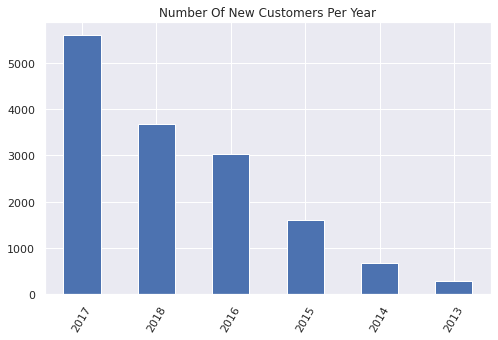

In [169]:
# Number Of New Customers Per Year
plt.title("Number Of New Customers Per Year")
profile_clean.year.value_counts().plot(kind='bar', figsize=(8,5))
plt.xticks(rotation=60)
plt.show()

It seems in 2017 Starbucks had a good advertisement strategy, because the most user started using the app in these year.

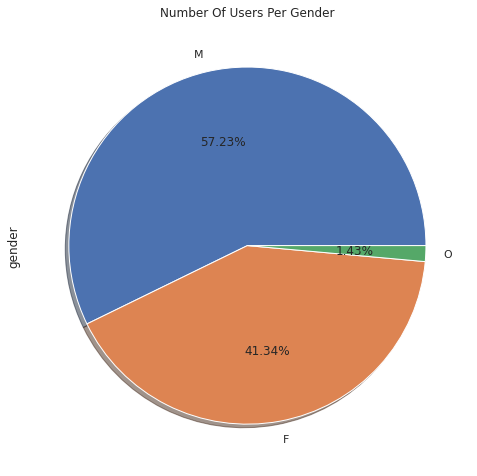

In [170]:
# Gender distribution
plt.title("Number Of Users Per Gender")
profile_clean.gender.value_counts().plot(kind='pie', figsize=(8,10), autopct='%1.2f%%', shadow=True)
plt.show()

From the gender distribution above we can see that 57% of the customers are males, where 41% are females.

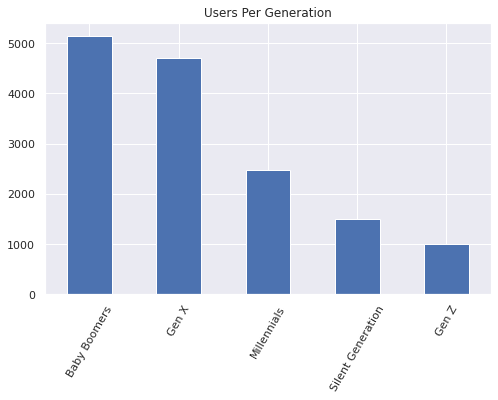

In [171]:
# Generation overview
plt.title("Users Per Generation")
profile_clean.generation.value_counts().plot(kind='bar', figsize=(8,5))
plt.xticks(rotation=60)
plt.show()

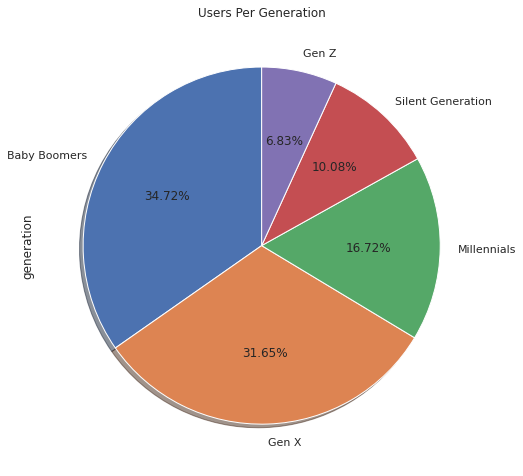

In [172]:
# Generation distribution
plt.title("Users Per Generation")
profile_clean.generation.value_counts().plot(kind='pie', figsize=(8,10), autopct='%1.2f%%', shadow=True, startangle=90)
plt.show()

It is interesting to see that the older generations (Baby Boomers and Gen X) use application the most.

In [173]:
transcript_clean.head()

,person,event,time,amount,gained_reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,0.0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.0,0.0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0


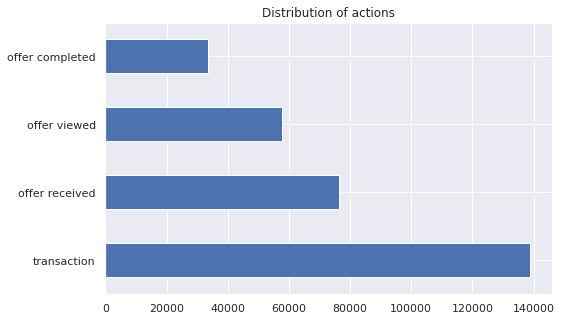

In [174]:
# Distribution of actions
plt.title("Distribution of actions")
transcript_clean.event.value_counts().plot.barh(figsize=(8,5))
plt.show()

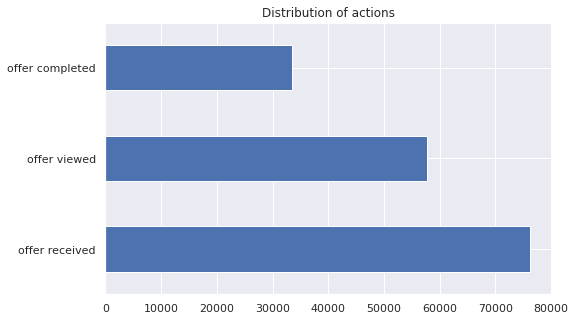

In [175]:
# Distribution of actions - transaction excluded
plt.title("Distribution of actions")
no_transaction = transcript_clean[transcript_clean.event != 'transaction']
no_transaction.event.value_counts().plot.barh(figsize=(8,5))
plt.show()

Looking at the chart above it is obvious that large number of customers ignore the offer or don't even viewed it.

In [176]:
transcript_portfolio = pd.merge(transcript_clean, portfolio_clean, how='left', on='offer_id')
transcript_portfolio.head()

,person,event,time,amount,gained_reward,offer_id,reward,difficulty,duration,offer_type,web,email,social,mobile
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,0.0,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.0,0.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


**I would like to examine top 50 customers in order to see which generations and which gender is more likely to spend more in starbucks.**

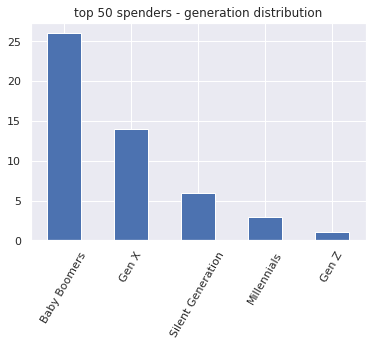

In [177]:
# top 50 by age group
top_customers = transcript_clean[(transcript_clean.amount != 0 )].groupby('person').amount.sum().reset_index().sort_values('amount', ascending=False)
top_50 = pd.merge(top_customers, profile_clean ,how='left',on='person').head(50)
top_50.generation.value_counts().plot(kind='bar', title='top 50 spenders - generation distribution')
plt.xticks(rotation=60)
plt.show()

From chart above is obvious that the Baby Boomer generation is the top spender generation.

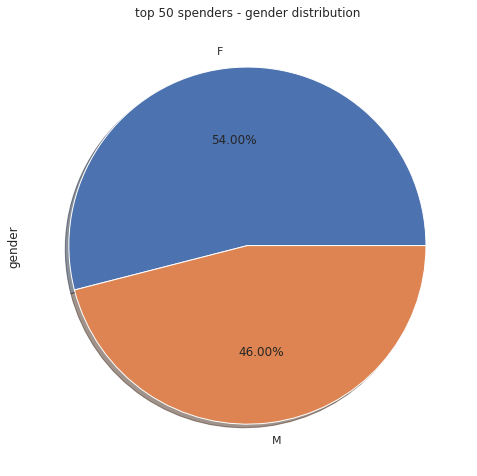

In [178]:
top_50.gender.value_counts().plot(kind='pie', title='top 50 spenders - gender distribution', figsize=(8,10), autopct='%1.2f%%', shadow=True)
plt.show()

There is slightly more males than females in top 50 customers.

**For further exploratory data analysis I want to merge all three dataframes in one dataframe**

In [160]:
def merge_data(portfolio,profile,transcript):
    """
    Merge cleaned data frames
       
    Parameters
    ---------- 
    portfolio : cleaned portfolio dataframe
    profile : cleaned profile dataframe
    transcript : cleaned transcript dataframe
      
    Returns
    -------
    merged_df: merged data frame
    
    """

    df = pd.merge(transcript, profile, how='left', on='person')
    df = pd.merge(df, portfolio, on='offer_id')
    
    return df

In [161]:
df_merged = merge_data(portfolio_clean, profile_clean, transcript_clean)
df_merged.head()

,person,event,time,amount,gained_reward,offer_id,gender,generation,year,income,reward,difficulty,duration,offer_type,web,email,social,mobile
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,Baby Boomers,2017.0,100000.0,5,5,7,bogo,1,1,0,1
1,ebe7ef46ea6f4963a7dd49f501b26779,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,Baby Boomers,2015.0,41000.0,5,5,7,bogo,1,1,0,1
2,f082d80f0aac47a99173ba8ef8fc1909,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,Millennials,2016.0,33000.0,5,5,7,bogo,1,1,0,1
3,c0d210398dee4a0895b24444a5fcd1d2,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,Gen X,2018.0,33000.0,5,5,7,bogo,1,1,0,1
4,57dd18ec5ddc46828afb81ec5977bef2,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,Gen X,2017.0,80000.0,5,5,7,bogo,1,1,0,1


In [162]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 167580
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   person         167581 non-null  object  
 1   event          167581 non-null  object  
 2   time           167581 non-null  int64   
 3   amount         167581 non-null  float64 
 4   gained_reward  167581 non-null  float64 
 5   offer_id       167581 non-null  object  
 6   gender         148805 non-null  object  
 7   generation     148805 non-null  category
 8   year           148805 non-null  float64 
 9   income         148805 non-null  float64 
 10  reward         167581 non-null  int64   
 11  difficulty     167581 non-null  int64   
 12  duration       167581 non-null  int64   
 13  offer_type     167581 non-null  object  
 14  web            167581 non-null  int64   
 15  email          167581 non-null  int64   
 16  social         167581 non-null  int64   
 17  mobile    

In [163]:
df_merged.isnull().sum()

person               0
event                0
time                 0
amount               0
gained_reward        0
offer_id             0
gender           18776
generation       18776
year             18776
income           18776
reward               0
difficulty           0
duration             0
offer_type           0
web                  0
email                0
social               0
mobile               0
dtype: int64

In [164]:
df_merged.describe()

,time,amount,gained_reward,year,income,reward,difficulty,duration,web,email,social,mobile
count,167581.000000,167581.0,167581.000000,148805.000000,148805.000000,167581.00000,167581.000000,167581.000000,167581.000000,167581.0,167581.000000,167581.000000
mean,353.778412,0.0,0.982665,2016.576365,66414.119149,4.41991,7.850401,6.610737,0.806858,1.0,0.656996,0.917944
std,198.301287,0.0,2.350137,1.186534,21496.947967,3.37336,5.048944,2.136130,0.394765,0.0,0.474714,0.274451
min,0.000000,0.0,0.000000,2013.000000,30000.000000,0.00000,0.000000,3.000000,0.000000,1.0,0.000000,0.000000
25%,168.000000,0.0,0.000000,2016.000000,51000.000000,2.00000,5.000000,5.000000,1.000000,1.0,0.000000,1.000000
50%,408.000000,0.0,0.000000,2017.000000,65000.000000,5.00000,10.000000,7.000000,1.000000,1.0,1.000000,1.000000
75%,510.000000,0.0,0.000000,2017.000000,81000.000000,5.00000,10.000000,7.000000,1.000000,1.0,1.000000,1.000000
max,714.000000,0.0,10.000000,2018.000000,120000.000000,10.00000,20.000000,10.000000,1.000000,1.0,1.000000,1.000000


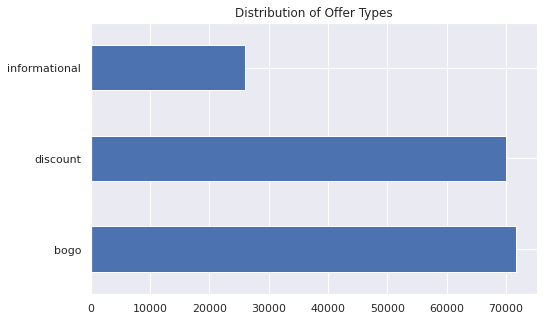

In [165]:
# Distribution of Offer Types
plt.title("Distribution of Offer Types")
df_merged.offer_type.value_counts().plot.barh(figsize=(8,5))
plt.show()

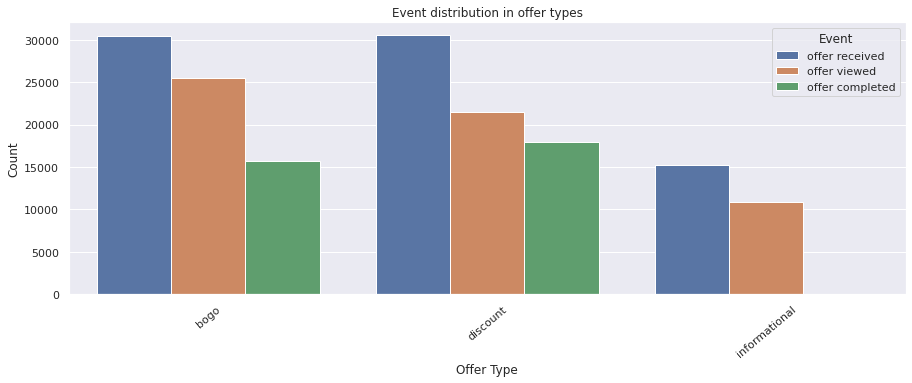

In [166]:
plt.figure(figsize=(15, 5))
sns.countplot(x="offer_type", hue="event", data=df_merged)
plt.title('Event distribution in offer types')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.xticks(rotation=40)
plt.legend(title='Event')
plt.show()

**It would be interesting to analyze the data based on generation**

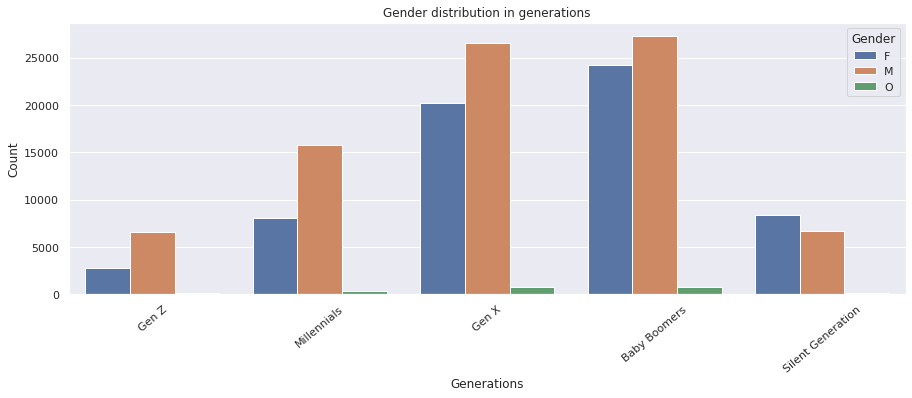

In [167]:
plt.figure(figsize=(15, 5))
sns.countplot(x="generation", hue="gender", data=df_merged)
plt.title('Gender distribution in generations')
plt.ylabel('Count')
plt.xlabel('Generations')
plt.xticks(rotation=40)
plt.legend(title='Gender')
plt.show()

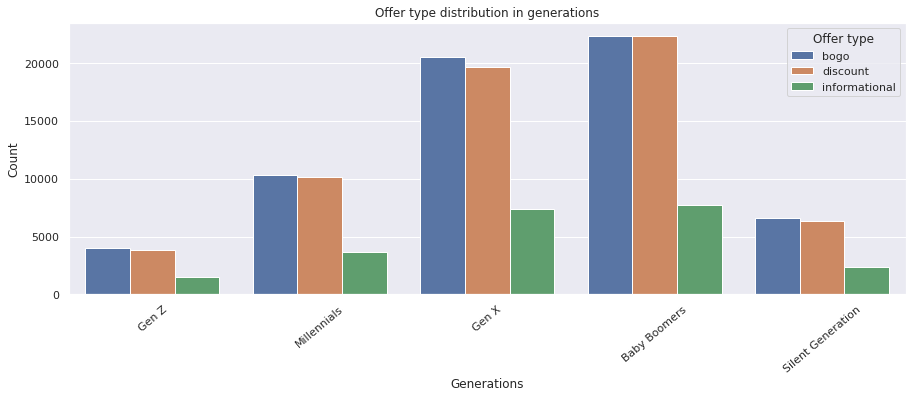

In [90]:
plt.figure(figsize=(15, 5))
sns.countplot(x="generation", hue="offer_type", data=df_merged)
plt.title('Offer type distribution in generations')
plt.ylabel('Count')
plt.xlabel('Generations')
plt.xticks(rotation=40)
plt.legend(title='Offer type')
plt.show()

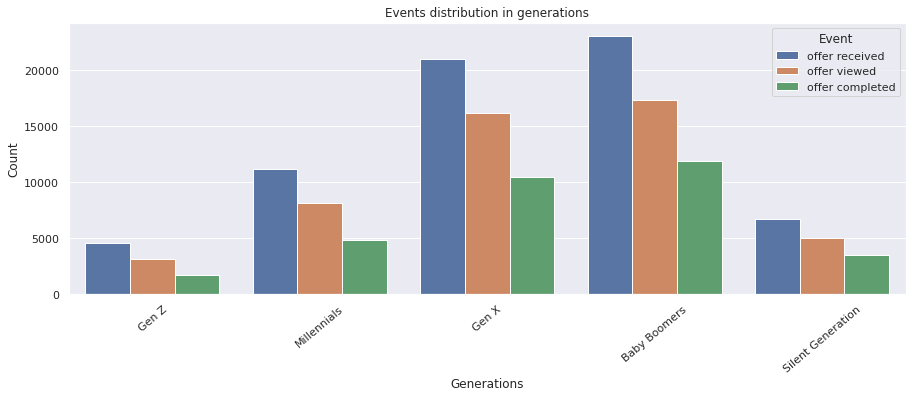

In [91]:
plt.figure(figsize=(15, 5))
sns.countplot(x="generation", hue="event", data=df_merged)
plt.title('Events distribution in generations')
plt.ylabel('Count')
plt.xlabel('Generations')
plt.xticks(rotation=40)
plt.legend(title='Event')
plt.show()

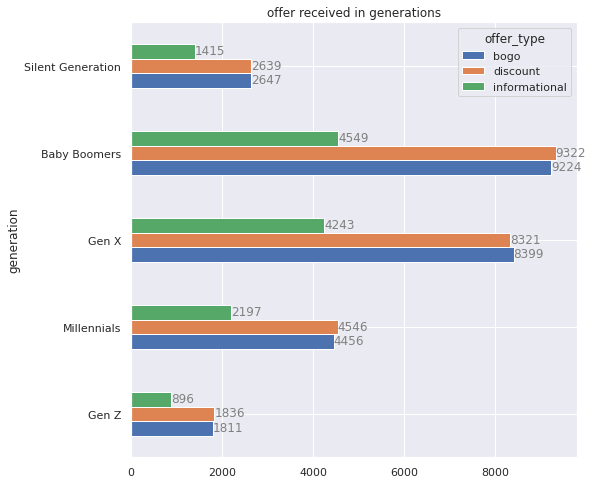

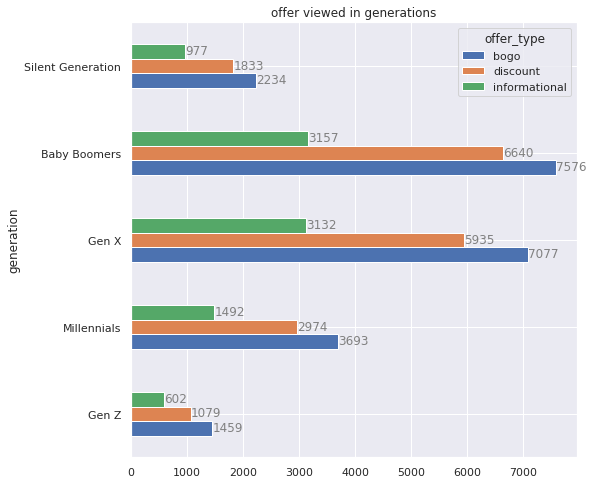

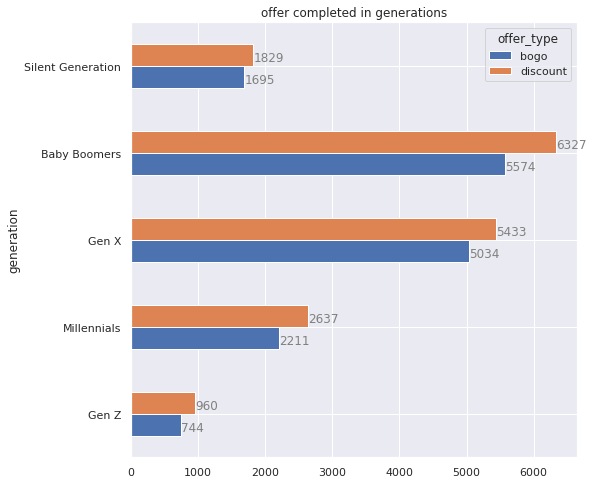

In [92]:
# generations, offers and events
for i in df_merged.event.unique():
    temp = df_merged[(df_merged.event == i )]
    t= pd.crosstab(temp["generation"],temp["offer_type"])
    if t.shape[0] != 0:
        ax = t.plot(kind="barh",figsize=(8, 8), title=i + ' in generations')
        for i in ax.patches:
            ax.text(i.get_width(), i.get_y()+.05, str(round((i.get_width()), 2)), color='grey')

## <a class="anchor" id="data-modeling">Data Modeling</a>

I want to build a model to predict which users are more likely to view and complete the offer

### Prepare the dataframe
Tasks:
 - encode categorical data such as gender, offer type, event and generation.
 - get only users who viewed offers then merge with users who completed offers
 - drop unnecessary columns
 - fill missing values

In [179]:
df_merged.head()

,person,event,time,amount,gained_reward,offer_id,gender,generation,year,income,reward,difficulty,duration,offer_type,web,email,social,mobile
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,Baby Boomers,2017.0,100000.0,5,5,7,bogo,1,1,0,1
1,ebe7ef46ea6f4963a7dd49f501b26779,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,Baby Boomers,2015.0,41000.0,5,5,7,bogo,1,1,0,1
2,f082d80f0aac47a99173ba8ef8fc1909,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,Millennials,2016.0,33000.0,5,5,7,bogo,1,1,0,1
3,c0d210398dee4a0895b24444a5fcd1d2,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,Gen X,2018.0,33000.0,5,5,7,bogo,1,1,0,1
4,57dd18ec5ddc46828afb81ec5977bef2,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,Gen X,2017.0,80000.0,5,5,7,bogo,1,1,0,1


In [180]:
dummies = pd.get_dummies(df_merged['offer_type'])
df_merged = pd.concat([df_merged, dummies], axis=1)


dummies = pd.get_dummies(df_merged['gender'])
df_merged = pd.concat([df_merged, dummies], axis=1)

dummies = pd.get_dummies(df_merged['event'])
df_merged = pd.concat([df_merged, dummies], axis=1)


dummies = pd.get_dummies(df_merged['generation'])
df_merged = pd.concat([df_merged, dummies], axis=1)

df_merged.head()

,person,event,time,amount,gained_reward,offer_id,gender,generation,year,income,...,M,O,offer completed,offer received,offer viewed,Gen Z,Millennials,Gen X,Baby Boomers,Silent Generation
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,Baby Boomers,2017.0,100000.0,...,0,0,0,1,0,0,0,0,1,0
1,ebe7ef46ea6f4963a7dd49f501b26779,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,Baby Boomers,2015.0,41000.0,...,1,0,0,1,0,0,0,0,1,0
2,f082d80f0aac47a99173ba8ef8fc1909,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,Millennials,2016.0,33000.0,...,1,0,0,1,0,0,1,0,0,0
3,c0d210398dee4a0895b24444a5fcd1d2,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,Gen X,2018.0,33000.0,...,1,0,0,1,0,0,0,1,0,0
4,57dd18ec5ddc46828afb81ec5977bef2,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,Gen X,2017.0,80000.0,...,0,0,0,1,0,0,0,1,0,0


In [181]:
# get offer viewed rows 
df_view = df_merged[df_merged['offer viewed'] == 1]
df_view.drop(['offer completed'], axis = 1, inplace=True)

df_view.head()

/home/josip.naletilic/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,person,event,time,amount,gained_reward,offer_id,gender,generation,year,income,...,F,M,O,offer received,offer viewed,Gen Z,Millennials,Gen X,Baby Boomers,Silent Generation
1245,c099206f76b1414db7552f163520053c,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
1246,4293153650e04742b310ac06cd3810e9,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,Gen X,2018.0,51000.0,...,1,0,0,0,1,0,0,1,0,0
1247,629fc02d56414d91bca360decdfa9288,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,Gen X,2018.0,72000.0,...,0,1,0,0,1,0,0,1,0,0
1249,6e43570e4517416cb3bcadd49d3da70f,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,Baby Boomers,2018.0,89000.0,...,0,1,0,0,1,0,0,0,1,0
1250,be7ff3cb6bf84ce395471e52b64b70c6,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,Baby Boomers,2018.0,66000.0,...,1,0,0,0,1,0,0,0,1,0


In [182]:
df_complete = df_merged[df_merged['offer completed'] == 1][['offer_id', 'person', 'offer completed']]
df_complete.head()

,offer_id,person,offer completed
1248,9b98b8c7a33c4b65b9aebfe6a799e6d9,629fc02d56414d91bca360decdfa9288,1
1254,9b98b8c7a33c4b65b9aebfe6a799e6d9,b860d355ef6e4c66b5d5a837c56ef32d,1
1255,9b98b8c7a33c4b65b9aebfe6a799e6d9,99297ea01107436fa8c2e2bc86f55d89,1
1263,9b98b8c7a33c4b65b9aebfe6a799e6d9,16dc4306258b4fef90ffe99f53ed7952,1
1267,9b98b8c7a33c4b65b9aebfe6a799e6d9,0454292436bd4cee98e8ec873e30433e,1


In [183]:
df_final = df_view.merge(df_complete, right_on=['offer_id','person'], left_on=['offer_id','person'], how='left')

df_final.head()

,person,event,time,amount,gained_reward,offer_id,gender,generation,year,income,...,M,O,offer received,offer viewed,Gen Z,Millennials,Gen X,Baby Boomers,Silent Generation,offer completed
0,c099206f76b1414db7552f163520053c,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,NaN
1,4293153650e04742b310ac06cd3810e9,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,Gen X,2018.0,51000.0,...,0,0,0,1,0,0,1,0,0,1.0
2,629fc02d56414d91bca360decdfa9288,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,Gen X,2018.0,72000.0,...,1,0,0,1,0,0,1,0,0,1.0
3,6e43570e4517416cb3bcadd49d3da70f,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,Baby Boomers,2018.0,89000.0,...,1,0,0,1,0,0,0,1,0,NaN
4,be7ff3cb6bf84ce395471e52b64b70c6,offer viewed,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,Baby Boomers,2018.0,66000.0,...,0,0,0,1,0,0,0,1,0,NaN


In [184]:
# drop unnecessary columns
df_final.drop(['offer_type','event','gender','year','gained_reward','person','offer_id',
               'time','offer received', 'offer viewed','generation'], axis = 1, inplace=True)

In [185]:
df_final.isnull().sum()

amount                   0
income                8034
reward                   0
difficulty               0
duration                 0
web                      0
email                    0
social                   0
mobile                   0
bogo                     0
discount                 0
informational            0
F                        0
M                        0
O                        0
Gen Z                    0
Millennials              0
Gen X                    0
Baby Boomers             0
Silent Generation        0
offer completed      28269
dtype: int64

In [186]:
# fill missing values
df_final.fillna(0, inplace=True)

df_final.head()

,amount,income,reward,difficulty,duration,web,email,social,mobile,bogo,...,informational,F,M,O,Gen Z,Millennials,Gen X,Baby Boomers,Silent Generation,offer completed
0,0.0,0.0,5,5,7,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0.0
1,0.0,51000.0,5,5,7,1,1,0,1,1,...,0,1,0,0,0,0,1,0,0,1.0
2,0.0,72000.0,5,5,7,1,1,0,1,1,...,0,0,1,0,0,0,1,0,0,1.0
3,0.0,89000.0,5,5,7,1,1,0,1,1,...,0,0,1,0,0,0,0,1,0,0.0
4,0.0,66000.0,5,5,7,1,1,0,1,1,...,0,1,0,0,0,0,0,1,0,0.0


In [191]:
df_final['offer completed'] = df_final['offer completed'].astype(int)

df_final.head()

,amount,income,reward,difficulty,duration,web,email,social,mobile,bogo,...,informational,F,M,O,Gen Z,Millennials,Gen X,Baby Boomers,Silent Generation,offer completed
0,0.0,0.0,5,5,7,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0.0,51000.0,5,5,7,1,1,0,1,1,...,0,1,0,0,0,0,1,0,0,1
2,0.0,72000.0,5,5,7,1,1,0,1,1,...,0,0,1,0,0,0,1,0,0,1
3,0.0,89000.0,5,5,7,1,1,0,1,1,...,0,0,1,0,0,0,0,1,0,0
4,0.0,66000.0,5,5,7,1,1,0,1,1,...,0,1,0,0,0,0,0,1,0,0


In [196]:
def create_model(classifer, df):    
    """
    a function that will create a model: train -> predict -> score -> print result
              
    args:
    classifer: object of classifer
    df: dataframe ready for training that must have "offer completed" column
    
    """
    
    print('Training with ' + str(classifer) + "...")
    
    features = df.drop(['offer completed'], axis = 1)
    target = df['offer completed']
    
    # split dataset
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)

    # fit classifier
    clf = classifer.fit(X_train, y_train)

    # predict on training and test data
    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

    # accuracy on training and test data
    score_train = accuracy_score( y_train , predict_train )
    score_test = accuracy_score( y_test , predict_test )

    # display classifier clf_result dict 
    print('Train Score:' , score_train)
    print('Test Score :', score_test)

In [197]:
create_model(AdaBoostClassifier(), df_final)
create_model(GaussianNB(), df_final)
create_model(DecisionTreeClassifier(), df_final)
create_model(RandomForestClassifier(), df_final)

Training with AdaBoostClassifier()...
Train Score: 0.809705023658512
Test Score : 0.8091326407344769
Training with GaussianNB()...
Train Score: 0.7909191583610188
Test Score : 0.7886566803575743
Training with DecisionTreeClassifier()...
Train Score: 0.8372697070371489
Test Score : 0.7890190867359266
Training with RandomForestClassifier()...
Train Score: 0.8372495721332931
Test Score : 0.7988040589514376


#### Model improvement (using GridSearchCV)

In [205]:
params = {
    'n_estimators': [38,39,40,42,43,44,45],
    'learning_rate' : [0.6,0.7,0.8,0.9],
    'algorithm':['SAMME', 'SAMME.R']
 }

# 'n_estimators': [50, 100,150,200],
# 'learning_rate' : [0.01,0.05,0.1,0.3,1],
# 'algorithm':['SAMME', 'SAMME.R']

# 'n_estimators': [40,45,50,55,60],
# 'learning_rate' : [0.8,0.9,1,1.1,1.2],
# 'algorithm':['SAMME', 'SAMME.R']

df = df_final.copy()
features = df.drop(['offer completed'], axis = 1)
target = df['offer completed']
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)
    
cv = GridSearchCV(AdaBoostClassifier(), param_grid=params, n_jobs = -1, scoring='accuracy')

cv.fit(X_train,y_train)

GridSearchCV(estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.6, 0.7, 0.8, 0.9],
                         'n_estimators': [38, 39, 40, 42, 43, 44, 45]},
             scoring='accuracy')

In [207]:
# The best parameters
cv.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.8, 'n_estimators': 42}

In [212]:
create_model(AdaBoostClassifier(algorithm='SAMME.R',learning_rate=0.8, n_estimators=42), df_final)

Training with AdaBoostClassifier(learning_rate=0.8, n_estimators=42)...
Train Score: 0.8095842142353771
Test Score : 0.8090118386083595
